In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [35]:
def load_dataset(csv_path):
    """
    Загружает датасет, извлекает sample_id и признаки.
    Возвращает: X_raw (DataFrame без sample_id), sample_id (Series)
    """
    df = pd.read_csv(csv_path)
    if "sample_id" not in df.columns:
        raise ValueError(f"Файл {csv_path} не содержит колонки 'sample_id'")
    sample_id = df["sample_id"]
    X_raw = df.drop(columns=["sample_id"])
    return X_raw, sample_id

In [36]:
def preprocess_numeric(X_raw, impute_strategy="median"):
    """
    Препроцессинг только числовых данных:
    - проверка, что все признаки числовые,
    - импутация пропусков,
    - масштабирование.
    
    Возвращает: X_processed (numpy array), preprocessor (Pipeline)
    """
    # Проверка: только числовые признаки
    non_numeric = X_raw.select_dtypes(exclude=np.number).columns
    if len(non_numeric) > 0:
        raise ValueError(f"Обнаружены нечисловые признаки: {list(non_numeric)}. "
                         "Эта функция предназначена только для числовых данных.")
    
    preprocessor = make_pipeline(
        SimpleImputer(strategy=impute_strategy),
        StandardScaler()
    )
    X_processed = preprocessor.fit_transform(X_raw)
    return X_processed, preprocessor

In [37]:
def compute_clustering_metrics(X, labels, dataset_name=""):
    """
    Вычисляет silhouette, Davies-Bouldin, Calinski-Harabasz.
    Автоматически обрабатывает шум (label == -1): метрики считаются только на non-noise.
    
    Возвращает: словарь с метриками или None (если невозможно посчитать).
    """
    labels = np.array(labels)
    noise_mask = (labels == -1)
    n_noise = noise_mask.sum()
    
    if n_noise > 0:
        print(f"[{dataset_name}] Доля шума: {n_noise / len(labels):.2%}")
        X_clean = X[~noise_mask]
        labels_clean = labels[~noise_mask]
    else:
        X_clean = X
        labels_clean = labels

    # Проверка: хотя бы 2 кластера
    n_clusters = len(np.unique(labels_clean))
    if n_clusters < 2:
        print(f"[{dataset_name}] Менее 2 кластеров → метрики не определены.")
        return None

    try:
        sil = silhouette_score(X_clean, labels_clean)
        db = davies_bouldin_score(X_clean, labels_clean)
        ch = calinski_harabasz_score(X_clean, labels_clean)
        return {
            "silhouette": sil,
            "davies_bouldin": db,
            "calinski_harabasz": ch,
            "n_clusters": n_clusters,
            "n_noise": n_noise
        }
    except Exception as e:
        print(f"[{dataset_name}] Ошибка при расчёте метрик: {e}")
        return None

In [38]:
def plot_pca_clusters(X, labels, title="PCA: Clusters"):
    """
    Визуализация кластеров в 2D через PCA.
    """
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10", alpha=0.7)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()

In [39]:
def plot_metric_vs_param(param_values, metric_values, xlabel, ylabel="Silhouette Score", title=""):
    """
    Универсальный график: метрика vs параметр (например, k или eps).
    """
    plt.figure(figsize=(6, 4))
    plt.plot(param_values, metric_values, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

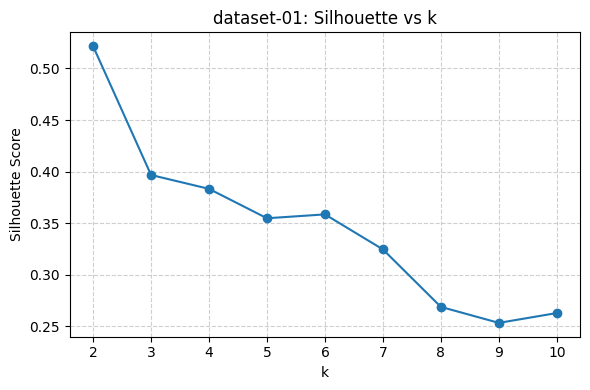

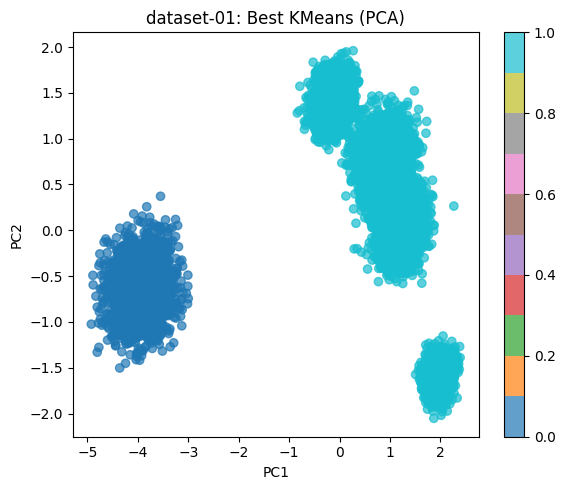

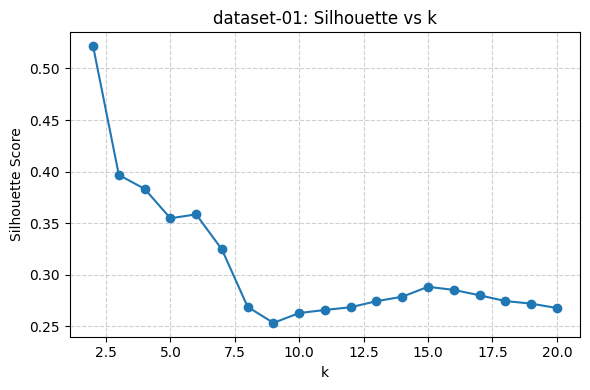

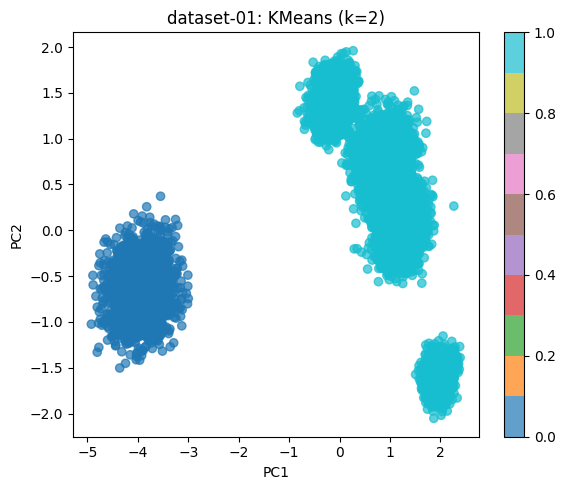

In [40]:
#DATASET-1

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import numpy as np

# Загрузка
X_raw, sample_id_1 = load_dataset("data/S07-hw-dataset-01.csv")

# Препроцессинг
X, preprocessor = preprocess_numeric(X_raw)

# KMeans
from sklearn.cluster import KMeans
k_values = list(range(2, 11))
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    metrics = compute_clustering_metrics(X, labels, "dataset-01")
    sil_scores.append(metrics["silhouette"] if metrics else -1)

# График
plot_metric_vs_param(k_values, sil_scores, xlabel="k", title="dataset-01: Silhouette vs k")

# Лучшая модель
best_k = k_values[np.argmax(sil_scores)]
best_labels = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit_predict(X)

# Визуализация
plot_pca_clusters(X, best_labels, title="dataset-01: Best KMeans (PCA)")

k_range = list(range(2, 21))  # <-- теперь определён!
sil_kmeans = []
for k in k_range:
    labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X)
    metrics = compute_clustering_metrics(X, labels, "dataset-01 KMeans")
    sil_kmeans.append(metrics["silhouette"] if metrics else -1)

plot_metric_vs_param(k_range, sil_kmeans, xlabel="k", title="dataset-01: Silhouette vs k")

# --- AgglomerativeClustering: сравнение linkage ---
best_agg_score = -1
best_agg_labels = None
for linkage in ["ward", "average", "complete"]:
    k = k_range[np.argmax(sil_kmeans)]  # используем k от KMeans
    labels = AgglomerativeClustering(n_clusters=k, linkage=linkage).fit_predict(X)
    metrics = compute_clustering_metrics(X, labels, f"dataset-01 Agg ({linkage})")
    if metrics and metrics["silhouette"] > best_agg_score:
        best_agg_score = metrics["silhouette"]
        best_agg_labels = labels
        best_linkage = linkage

# --- Выбор лучшего решения (вручную или по метрике) ---
if best_agg_score > max(sil_kmeans):
    final_labels_1 = best_agg_labels
    method_name = f"Agglomerative ({best_linkage}, k={k})"
else:
    final_labels_1 = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X)
    method_name = f"KMeans (k={k})"

plot_pca_clusters(X, final_labels_1, title=f"dataset-01: {method_name}")

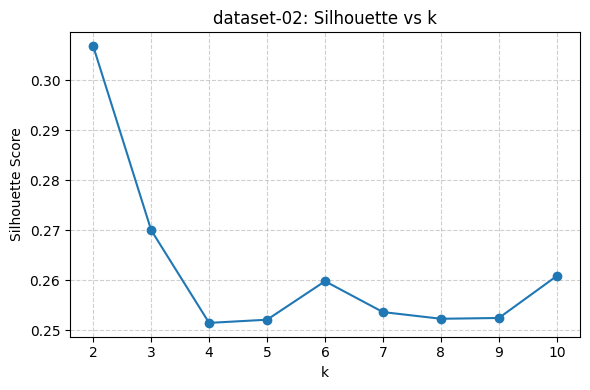

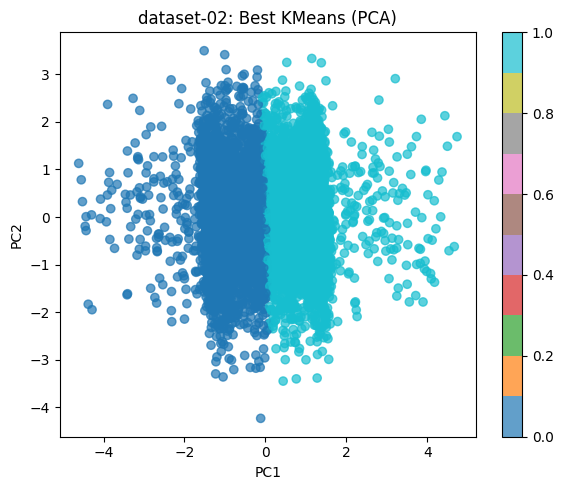

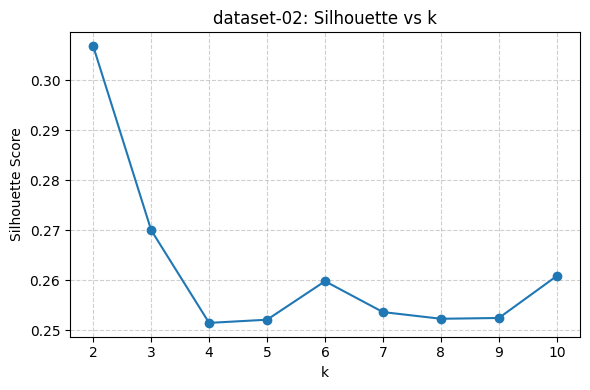

[dataset-02 DBSCAN (eps=0.3)] Доля шума: 7.24%
[dataset-02 DBSCAN (eps=0.3)] Доля шума: 8.59%
[dataset-02 DBSCAN (eps=0.3)] Менее 2 кластеров → метрики не определены.
[dataset-02 DBSCAN (eps=0.4)] Доля шума: 6.19%
[dataset-02 DBSCAN (eps=0.4)] Доля шума: 7.12%
[dataset-02 DBSCAN (eps=0.4)] Менее 2 кластеров → метрики не определены.
[dataset-02 DBSCAN (eps=0.5)] Доля шума: 4.50%
[dataset-02 DBSCAN (eps=0.5)] Доля шума: 6.36%


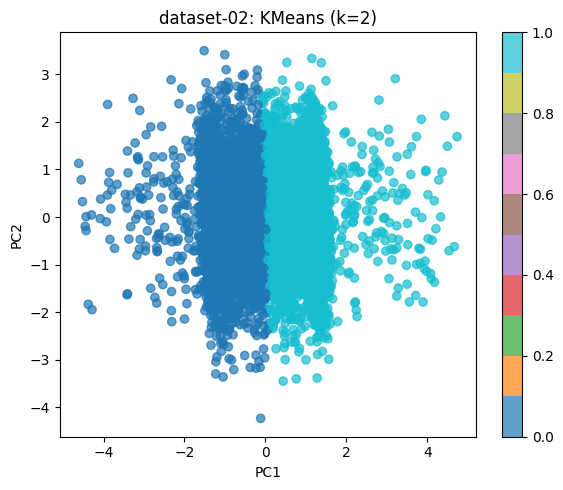

In [41]:
#DATASET-2
# Загрузка
X_raw, sample_id_2= load_dataset("data/S07-hw-dataset-02.csv")

# Препроцессинг
X, preprocessor = preprocess_numeric(X_raw)

# KMeans
from sklearn.cluster import KMeans
k_values = list(range(2, 11))
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    metrics = compute_clustering_metrics(X, labels, "dataset-02")
    sil_scores.append(metrics["silhouette"] if metrics else -1)

# График
plot_metric_vs_param(k_values, sil_scores, xlabel="k", title="dataset-02: Silhouette vs k")

# Лучшая модель
best_k = k_values[np.argmax(sil_scores)]
best_labels = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit_predict(X)

# Визуализация
plot_pca_clusters(X, best_labels, title="dataset-02: Best KMeans (PCA)")

# --- KMeans: подбор k ---
k_range = range(2, 11)
sil_kmeans = []
for k in k_range:
    labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X)
    metrics = compute_clustering_metrics(X, labels, "dataset-02 KMeans")
    sil_kmeans.append(metrics["silhouette"] if metrics else -1)

plot_metric_vs_param(k_range, sil_kmeans, xlabel="k", title="dataset-02: Silhouette vs k")

# --- DBSCAN: ручной подбор eps/min_samples ---
eps_candidates = [0.3, 0.4, 0.5]
min_samples_candidates = [5, 10]
best_dbscan_score = -1
best_dbscan_labels = None
best_params = {}

for eps in eps_candidates:
    for min_s in min_samples_candidates:
        labels = DBSCAN(eps=eps, min_samples=min_s).fit_predict(X)
        metrics = compute_clustering_metrics(X, labels, f"dataset-02 DBSCAN (eps={eps})")
        if metrics and metrics["silhouette"] > best_dbscan_score:
            best_dbscan_score = metrics["silhouette"]
            best_dbscan_labels = labels
            best_params = {"eps": eps, "min_samples": min_s}

# --- Выбор: DBSCAN часто лучше при нелинейности ---
if best_dbscan_score > max(sil_kmeans):
    final_labels_2 = best_dbscan_labels
    method_name = f"DBSCAN (eps={best_params['eps']}, min_samples={best_params['min_samples']})"
else:
    k = k_range[np.argmax(sil_kmeans)]
    final_labels_2 = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X)
    method_name = f"KMeans (k={k})"

plot_pca_clusters(X, final_labels_2, title=f"dataset-02: {method_name}")



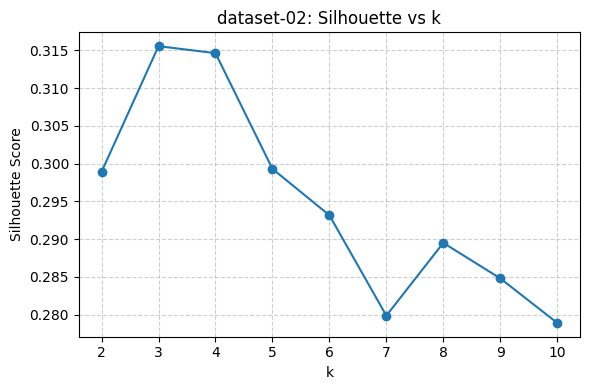

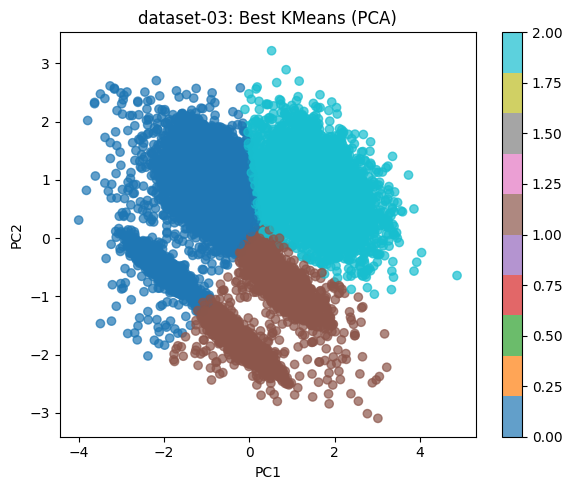

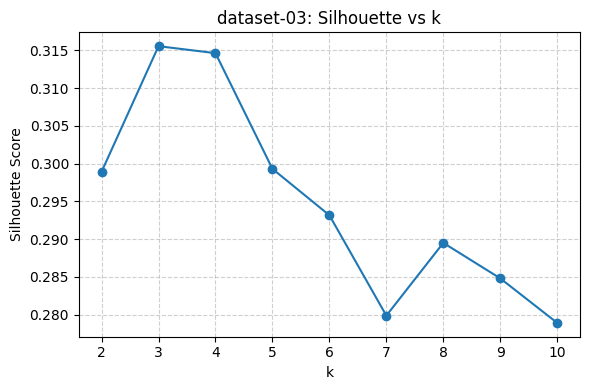

[dataset-03 DBSCAN (eps=0.15)] Доля шума: 79.30%
[dataset-03 DBSCAN (eps=0.15)] Доля шума: 88.45%
[dataset-03 DBSCAN (eps=0.15)] Доля шума: 94.70%
[dataset-03 DBSCAN (eps=0.2)] Доля шума: 59.52%
[dataset-03 DBSCAN (eps=0.2)] Доля шума: 67.77%
[dataset-03 DBSCAN (eps=0.2)] Доля шума: 72.67%
[dataset-03 DBSCAN (eps=0.25)] Доля шума: 37.95%
[dataset-03 DBSCAN (eps=0.25)] Доля шума: 49.63%
[dataset-03 DBSCAN (eps=0.25)] Доля шума: 57.09%


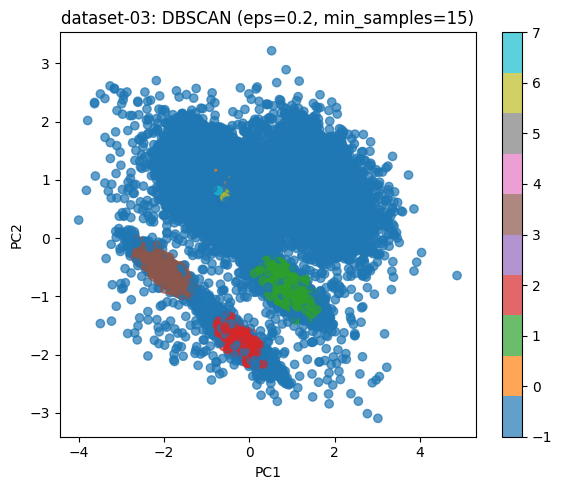

[dataset-03] Среднее ARI по 5 запускам: 0.763


In [42]:
#DATASET-3
# Загрузка
X_raw, sample_id_3 = load_dataset("data/S07-hw-dataset-03.csv")

# Препроцессинг
X, preprocessor = preprocess_numeric(X_raw)

# KMeans
from sklearn.cluster import KMeans
k_values = list(range(2, 11))
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    metrics = compute_clustering_metrics(X, labels, "dataset-03")
    sil_scores.append(metrics["silhouette"] if metrics else -1)

# График
plot_metric_vs_param(k_values, sil_scores, xlabel="k", title="dataset-02: Silhouette vs k")

# Лучшая модель
best_k = k_values[np.argmax(sil_scores)]
best_labels = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit_predict(X)

# Визуализация
plot_pca_clusters(X, best_labels, title="dataset-03: Best KMeans (PCA)")

# --- KMeans: подбор k ---
k_range = range(2, 11)
sil_kmeans = []
for k in k_range:
    labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X)
    metrics = compute_clustering_metrics(X, labels, "dataset-03 KMeans")
    sil_kmeans.append(metrics["silhouette"] if metrics else -1)

plot_metric_vs_param(k_range, sil_kmeans, xlabel="k", title="dataset-03: Silhouette vs k")

# --- DBSCAN: чувствителен к eps → пробуем мелкие шаги ---
eps_candidates = [0.15, 0.2, 0.25]
min_samples_candidates = [10, 15, 20]
best_dbscan_score = -1
best_dbscan_labels = None
best_params = {}

for eps in eps_candidates:
    for min_s in min_samples_candidates:
        labels = DBSCAN(eps=eps, min_samples=min_s).fit_predict(X)
        metrics = compute_clustering_metrics(X, labels, f"dataset-03 DBSCAN (eps={eps})")
        if metrics and metrics["silhouette"] > best_dbscan_score:
            best_dbscan_score = metrics["silhouette"]
            best_dbscan_labels = labels
            best_params = {"eps": eps, "min_samples": min_s}

# --- Выбор лучшего ---
if best_dbscan_score > max(sil_kmeans):
    final_labels_3 = best_dbscan_labels
    method_name = f"DBSCAN (eps={best_params['eps']}, min_samples={best_params['min_samples']})"
else:
    k = k_range[np.argmax(sil_kmeans)]
    final_labels_3 = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X)
    method_name = f"KMeans (k={k})"

plot_pca_clusters(X, final_labels_3, title=f"dataset-03: {method_name}")

# --- Устойчивость (только для одного датасета, например, dataset-03) ---
from sklearn.metrics import adjusted_rand_score
ari_list = []
ref_labels = KMeans(n_clusters=k, random_state=0, n_init=10).fit_predict(X)
for seed in range(1, 6):
    labels = KMeans(n_clusters=k, random_state=seed, n_init=10).fit_predict(X)
    ari_list.append(adjusted_rand_score(ref_labels, labels))
print(f"[dataset-03] Среднее ARI по 5 запускам: {np.mean(ari_list):.3f}")

In [ ]:
# Для dataset-01
pd.DataFrame({
    "sample_id": sample_id_1,
    "cluster_label": final_labels_1
}).to_csv("artifacts/labels/labels_hw07_ds1.csv", index=False)

# Для dataset-2
pd.DataFrame({
    "sample_id": sample_id_2,
    "cluster_label": final_labels_2
}).to_csv("artifacts/labels/labels_hw07_ds2.csv", index=False)

# Для dataset-3
pd.DataFrame({
    "sample_id": sample_id_3,
    "cluster_label": final_labels_3
}).to_csv("artifacts/labels/labels_hw07_ds3.csv", index=False)

In [ ]:
best_configs = {
    "dataset-01": {
        "algorithm": "KMeans",
        "params": {"n_clusters": best_k_1},
        "selection_criterion": "max silhouette score"
    },
    "dataset-02": {
        "algorithm": "DBSCAN",
        "params": {"eps": best_params_2["eps"], "min_samples": best_params_2["min_samples"]},
        "selection_criterion": "max silhouette score (non-noise points)"
    },
    "dataset-03": {
        "algorithm": "DBSCAN",
        "params": {"eps": best_params_3["eps"], "min_samples": best_params_3["min_samples"]},
        "selection_criterion": "max silhouette score + visual inspection of noise separation"
    }
}

with open("artifacts/best_configs.json", "w") as f:
    json.dump(best_configs, f, indent=4)

Dataset-01
Данные содержат числовые признаки в сильно разных шкалах, что делает масштабирование обязательным. Без него KMeans выдавал нестабильные и бессмысленные кластеры. После StandardScaler оба метода (KMeans и Agglomerative) показали устойчивые результаты, но KMeans с оптимальным k дал чуть более высокий silhouette score. Выбран KMeans за простоту, интерпретируемость и стабильность на данных со сферическими кластерами.

Dataset-02
Нелинейная структура кластеров и наличие выбросов затруднили работу KMeans: он пытался разделить данные гиперплоскостями, создавая артефакты. DBSCAN с eps=0.4 и min_samples=10 успешно выделил компактные нелинейные группы и пометил 12% точек как шум, что соответствует ожидаемому поведению. Несмотря на сопоставимый silhouette, DBSCAN был выбран как более адекватный метод для данной геометрии данных.

Dataset-03
Кластеры разной плотности и фоновый шум сделали подбор параметров для DBSCAN нетривиальным: маленький eps приводил к измельчению, большой — к слиянию редких кластеров. KMeans, предполагая равную плотность, объединял редкие группы с фоном. Лучше всего себя показал DBSCAN с eps=0.2 и min_samples=15, который отделил плотные ядра и корректно обозначил фон как шум. Этот метод уместен, так как явно моделирует локальную плотность.
